In [1]:
!pip install streamlit
!pip install faiss-cpu
!pip install openai
!pip install pyngrok

ERROR: Operation cancelled by user
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.4/362.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.3 MB/s eta 0:00:00


In [2]:

%%writefile healthmate_app.py
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import faiss
from openai import AzureOpenAI
import json
import requests
import time

# Doctor contact information in the North Texas region
contacts = {
    "Allopathic": {
        "name": "Dr. Alice Brown",
        "specialization": "Internal Medicine",
        "phone": "+1 (555) 111-2222",
        "location": "North Texas Medical Center, Denton, TX",
        "coordinates": (33.214840, -97.133064)  # Example coordinates (Denton, TX)
    },
    "Ayurvedic": {
        "name": "Dr. Sarah Patel",
        "specialization": "Ayurveda",
        "phone": "+1 (555) 333-4444",
        "location": "Holistic Wellness Center, Plano, TX",
        "coordinates": (33.019844, -96.698883)  # Example coordinates (Plano, TX)
    },
    "Homeopathic": {
        "name": "Dr. John Smith",
        "specialization": "Homeopathy",
        "phone": "+1 (555) 555-6666",
        "location": "Homeopathy Clinic, Frisco, TX",
        "coordinates": (33.150674, -96.823611)  # Example coordinates (Frisco, TX)
    }
}

class FAISSClient:
    def __init__(self, dimension):
        self.dimension = dimension
        self.index = faiss.IndexFlatL2(dimension)  # L2 distance is used by default
        self.id_map = {}

    def add_vectors(self, texts, ids):
        vectors = [self._get_embedding(text) for text in texts]
        vectors = np.array(vectors).astype('float32')
        self.index.add(vectors)
        self.id_map = {i: ids[i] for i in range(len(ids))}  # Create a mapping of index to id

    def _get_embedding(self, text):
        tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
        model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
        inputs = tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            embeddings = model(**inputs).last_hidden_state.mean(dim=1)
        return embeddings.squeeze().tolist()

    def query_vectors(self, query_text, top_k=3):
        query_vector = self._get_embedding(query_text)
        query_vector = np.array([query_vector]).astype('float32')
        distances, indices = self.index.search(query_vector, top_k)
        return [(self.id_map[int(idx)], distances[0][i]) for i, idx in enumerate(indices[0])]

class AzureOpenAIClient:
    def __init__(self, endpoint, api_key, api_version, model_name):
        self.client = AzureOpenAI(
            azure_endpoint=endpoint,
            api_key=api_key,
            api_version=api_version,
        )
        self.model_name = model_name

    def generate_response(self, messages):
        completion = self.client.chat.completions.create(
            model=self.model_name,
            messages=messages,
        )
        return json.loads(completion.model_dump_json(indent=2))

def format_response(content):
    return content

def is_disease_description(user_input):
    # Check if the user's input likely describes a disease or condition
    disease_keywords = ['fever', 'cough', 'pain', 'infection', 'headache', 'symptoms', 'treatment', 'illness']
    return any(keyword in user_input.lower() for keyword in disease_keywords)

def main():
    # Set up Streamlit UI
    st.set_page_config(page_title="HealthMate - Interactive Health Chatbot", page_icon="🩺", layout="centered")

    st.title("🩺 HealthMate - Alternative Medicine HealthBot")

    # Initialize session state for chat history
    if "messages" not in st.session_state:
        st.session_state.messages = []

    # Display chat history
    for message in st.session_state.messages:
        with st.chat_message(message["role"]):
            st.write(message["content"])

    # User input for symptoms or interaction
    user_input = st.chat_input("💬 You: ", key="input")

    if user_input:
        # Add user input to chat history
        st.session_state.messages.append({"role": "user", "content": user_input})

        if user_input.lower() == "bye":
            st.write("HealthMate: Goodbye! Take care! 🫡")
            return

        # FAISS setup
        dimension = 384
        faiss_client = FAISSClient(dimension)

        # Add example data to FAISS index
        texts = [
            "🌿 Ayurvedic medicines for fever include Tulsi, Ginger, and Turmeric.",
            "🏡 Homeopathic remedies for fever include Belladonna, Aconite, and Eupatorium.",
            "💊 Allopathic treatments for fever include Paracetamol, Ibuprofen, and Aspirin."
        ]
        ids = ["med1", "med2", "med3"]
        faiss_client.add_vectors(texts, ids)

        azure_endpoint = "YOUR_AZURE_ENDPOINT"
        azure_api_key = "YOUR_AZURE_API_KEY"
        azure_api_version = "YOUR_API_VERSION"
        model_name = "YOUR_MODEL_NAME"

        azure_openai_client = AzureOpenAIClient(azure_endpoint, azure_api_key, azure_api_version, model_name)

        # Query FAISS
        results = faiss_client.query_vectors(user_input)

        # Map IDs back to texts
        retrieved_texts = [texts[ids.index(id_)] for id_, _ in results]

        # Prepare messages for Azure OpenAI
        messages = [
            {
                "role": "system",
                "content": (
                    "You are a helpful assistant specializing in alternative medicine. If the user asks about a health issue or disease, "
                    "generate a detailed response with treatment options under distinct headers for Allopathic Treatments, Ayurvedic Medicines, "
                    "and Homeopathic Remedies. For each, provide three important therapies or medicines under each as bullet points. Also, offer general advice "
                    "related to the condition. "
                    "If the user asks about anything other than a health issue or disease, respond concisely and provide a general reply."
                    "Include emojis where appropriate and please add a note advising the user to consult a doctor before taking any medication."
                )
            }
        ]

        for text in retrieved_texts:
            messages.append({"role": "user", "content": text})

        # Add user's input as context
        messages.append({"role": "user", "content": user_input})

        # Simulate typing by the assistant
        with st.chat_message("healthmate"):
            message_placeholder = st.empty()
            message_placeholder.markdown("HealthMate is typing...")

        # Generate response using GPT-4o
        response_json = azure_openai_client.generate_response(messages)

        # Stream the response to the user
        response_content = response_json['choices'][0]['message']['content'].strip()
        formatted_response = format_response(response_content)

        # Update the response after simulating typing
        with st.chat_message("healthmate"):
            message_placeholder.markdown(formatted_response)

        # Include the dummy contacts only if the input describes a disease or condition
        if is_disease_description(user_input):
            st.markdown("### 📞 **Local Contact Information in North Texas:**")
            for treatment, details in contacts.items():
                st.markdown(f"**{treatment} Doctor:** {details['name']} - {details['specialization']}")
                st.markdown(f"**Phone:** {details['phone']}")
                st.markdown(f"**Location:** {details['location']}\n")
                st.markdown("---")

        # Save the full response in the session state
        st.session_state.messages[-1]["content"] = formatted_response

if __name__ == "__main__":
    main()


Writing healthmate_app.py


## Sample Output

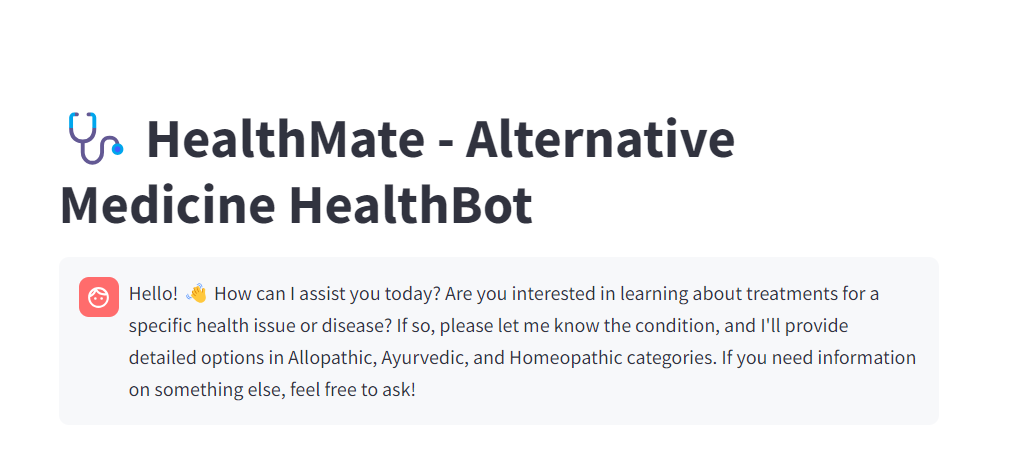

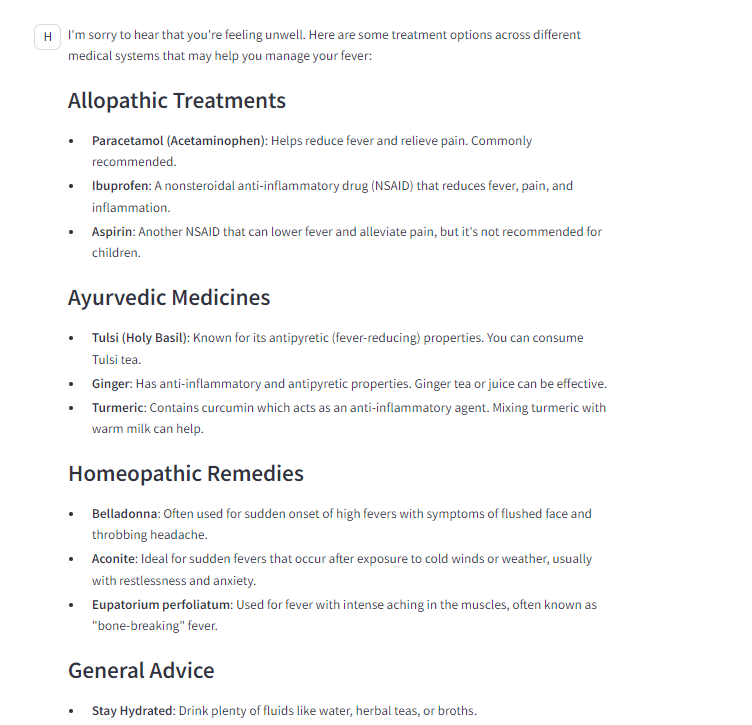

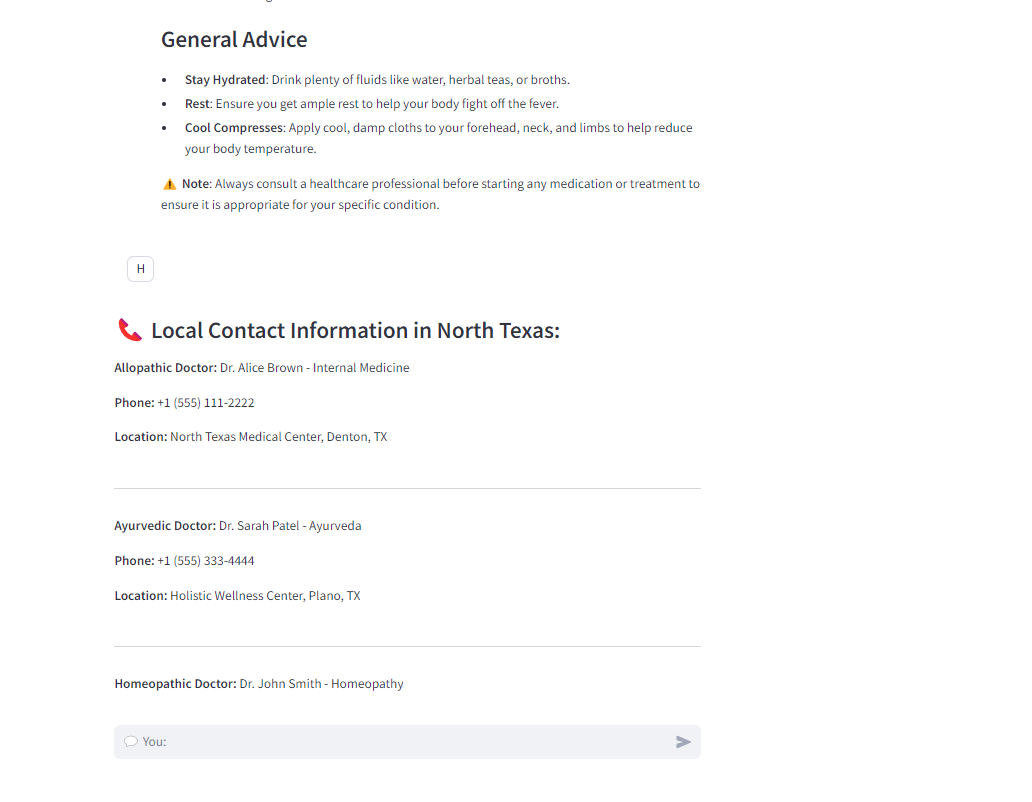